# Machine Learning Interpretation using SHAP

###### importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import pearsonr
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib

###### loading data

In [2]:
train = pd.read_excel('walkertrain.xlsx')
test = pd.read_excel('walkertest.xlsx')

In [3]:
x_tr = train[['x','y']]
y_tr = train[['v']]

x_te = test[['x','y']]
y_te = test['v']

###### preparing data

In [4]:
###
dst_tr = distance.cdist(x_tr,x_tr, "euclidean")
xtrain = np.concatenate((x_tr, dst_tr), axis = 1)

###
dst_te = distance.cdist(x_te,x_tr, "euclidean")
xtest = np.concatenate((x_te, dst_te), axis = 1)

###### Model Fitting

In [5]:
rf = RandomForestRegressor(50,random_state=42)
rf.fit(xtrain,y_tr.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [6]:
y_test_best = rf.predict(xtest)

In [7]:
print(f"Test pearsonr: {pearsonr(y_te.values, y_test_best)[0]}")

Test pearsonr: 0.7906636590158407


# Interpreting Machine Learning Models

A prediction can be explained by assuming that each feature value of the instance is a “player” in a game where the prediction is the payout. Shapley values – a method from coalitional game theory – tells us how to fairly distribute the “payout” among the features.

**Assume the following scenario:**

You have trained a machine learning model to predict apartment prices. For a certain apartment it predicts €300,000 and you need to explain this prediction. The apartment has a size of 50 sq.meter, is located on the 2nd floor, has a park nearby and cats are banned:

The average prediction for all apartments is €310,000. How much has each feature value contributed to the prediction compared to the average prediction?

Our goal is to explain the difference between the actual prediction (€300,000) and the average prediction (€310,000): a difference of -€10,000.

The answer could be: The park-nearby contributed €30,000; size-50 contributed €10,000; floor-2nd contributed €0; cat-banned contributed -€50,000. The contributions add up to -€10,000, the final prediction minus the average predicted apartment price.

**How do we calculate the Shapley value for one feature?**

The Shapley value is the average marginal contribution of a feature value across all possible coalitions. All clear now?

In the following figure we evaluate the contribution of the cat-banned feature value when it is added to a coalition of park-nearby and size-50. 

We simulate that only park-nearby, cat-banned and size-50 are in a coalition by randomly drawing another apartment from the data and using its value for the floor feature. 

The value floor-2nd was replaced by the randomly drawn floor-1st. Then we predict the price of the apartment with this combination (€310,000). 

In a second step, we remove cat-banned from the coalition by replacing it with a random value of the cat allowed/banned feature from the randomly drawn apartment. In the example it was cat-allowed, but it could have been cat-banned again. We predict the apartment price for the coalition of park-nearby and size-50 (€320,000). 

The contribution of cat-banned was €310,000 - €320,000 = -€10.000. This estimate depends on the values of the randomly drawn apartment that served as a “donor” for the cat and floor feature values. We will get better estimates if we repeat this sampling step and average the contributions.

**We repeat this computation for all possible coalitions.** 

The Shapley value is the average of all the marginal contributions to all possible coalitions. The computation time increases exponentially with the number of features. One solution to keep the computation time manageable is to compute contributions for only a few samples of the possible coalitions.

The following list shows all coalitions of feature values that are needed to determine the Shapley value for cat-banned. The first row shows the coalition without any feature values. The second, third and fourth rows show different coalitions with increasing coalition size, separated by “|”. All in all, the following coalitions are possible:

No feature values

park-nearby

size-50

floor-2nd

park-nearby+size-50

park-nearby+floor-2nd

size-50+floor-2nd

park-nearby+size-50+floor-2nd.

For each of these coalitions we compute the predicted apartment price with and without the feature value cat-banned and take the difference to get the marginal contribution. 

**The Shapley value is the (weighted) average of marginal contributions.**

We replace the feature values of features that are not in a coalition with random feature values from the apartment dataset to get a prediction from the machine learning model.

If we estimate the Shapley values for all feature values, we get the complete distribution of the prediction (minus the average) among the feature values.

###### SHAP Implementation

Let's apply **SHAP (SHapley Additive exPlanations)**, a cutting edge method that explains predictions made by black-box machine learning models (i.e. models which are too complex to be understandable by humans as is).

> Given a prediction made by a machine learning model, SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, where Shapley values are used to quantify the contribution of each player to the game.
> 
> Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm. For more details, see the [TreeShap paper](https://arxiv.org/pdf/1802.03888.pdf).

We'll use the [shap library](https://github.com/slundberg/shap) to do this for our random forest model. 

Let's try for first sample i.e. i=0

Before that let's prepare data for shap

In [8]:
columns  = ["sample"+str(i) for i in range(470)]
columns.insert(0,'x')
columns.insert(1,'y')
columns

['x',
 'y',
 'sample0',
 'sample1',
 'sample2',
 'sample3',
 'sample4',
 'sample5',
 'sample6',
 'sample7',
 'sample8',
 'sample9',
 'sample10',
 'sample11',
 'sample12',
 'sample13',
 'sample14',
 'sample15',
 'sample16',
 'sample17',
 'sample18',
 'sample19',
 'sample20',
 'sample21',
 'sample22',
 'sample23',
 'sample24',
 'sample25',
 'sample26',
 'sample27',
 'sample28',
 'sample29',
 'sample30',
 'sample31',
 'sample32',
 'sample33',
 'sample34',
 'sample35',
 'sample36',
 'sample37',
 'sample38',
 'sample39',
 'sample40',
 'sample41',
 'sample42',
 'sample43',
 'sample44',
 'sample45',
 'sample46',
 'sample47',
 'sample48',
 'sample49',
 'sample50',
 'sample51',
 'sample52',
 'sample53',
 'sample54',
 'sample55',
 'sample56',
 'sample57',
 'sample58',
 'sample59',
 'sample60',
 'sample61',
 'sample62',
 'sample63',
 'sample64',
 'sample65',
 'sample66',
 'sample67',
 'sample68',
 'sample69',
 'sample70',
 'sample71',
 'sample72',
 'sample73',
 'sample74',
 'sample75',
 'sample76',
 'sample77',
 'sample78',
 'sample79',
 'sample80',
 'sample81',
 'sample82',
 'sample83',
 'sample84',
 'sample85',
 'sample86',
 'sample87',
 'sample88',
 'sample89',
 'sample90',
 'sample91',
 'sample92',
 'sample93',
 'sample94',
 'sample95',
 'sample96',
 'sample97',
 'sample98',
 'sample99',
 'sample100',
 'sample101',
 'sample102',
 'sample103',
 'sample104',
 'sample105',
 'sample106',
 'sample107',
 'sample108',
 'sample109',
 'sample110',
 'sample111',
 'sample112',
 'sample113',
 'sample114',
 'sample115',
 'sample116',
 'sample117',
 'sample118',
 'sample119',
 'sample120',
 'sample121',
 'sample122',
 'sample123',
 'sample124',
 'sample125',
 'sample126',
 'sample127',
 'sample128',
 'sample129',
 'sample130',
 'sample131',
 'sample132',
 'sample133',
 'sample134',
 'sample135',
 'sample136',
 'sample137',
 'sample138',
 'sample139',
 'sample140',
 'sample141',
 'sample142',
 'sample143',
 'sample144',
 'sample145',
 'sample146',
 'sample147',
 'sample148',
 'sample149',
 'sample150',
 'sample151',
 'sample152',
 'sample153',
 'sample154',
 'sample155',
 'sample156',
 'sample157',
 'sample158',
 'sample159',
 'sample160',
 'sample161',
 'sample162',
 'sample163',
 'sample164',
 'sample165',
 'sample166',
 'sample167',
 'sample168',
 'sample169',
 'sample170',
 'sample171',
 'sample172',
 'sample173',
 'sample174',
 'sample175',
 'sample176',
 'sample177',
 'sample178',
 'sample179',
 'sample180',
 'sample181',
 'sample182',
 'sample183',
 'sample184',
 'sample185',
 'sample186',
 'sample187',
 'sample188',
 'sample189',
 'sample190',
 'sample191',
 'sample192',
 'sample193',
 'sample194',
 'sample195',
 'sample196',
 'sample197',
 'sample198',
 'sample199',
 'sample200',
 'sample201',
 'sample202',
 'sample203',
 'sample204',
 'sample205',
 'sample206',
 'sample207',
 'sample208',
 'sample209',
 'sample210',
 'sample211',
 'sample212',
 'sample213',
 'sample214',
 'sample215',
 'sample216',
 'sample217',
 'sample218',
 'sample219',
 'sample220',
 'sample221',
 'sample222',
 'sample223',
 'sample224',
 'sample225',
 'sample226',
 'sample227',
 'sample228',
 'sample229',
 'sample230',
 'sample231',
 'sample232',
 'sample233',
 'sample234',
 'sample235',
 'sample236',
 'sample237',
 'sample238',
 'sample239',
 'sample240',
 'sample241',
 'sample242',
 'sample243',
 'sample244',
 'sample245',
 'sample246',
 'sample247',
 'sample248',
 'sample249',
 'sample250',
 'sample251',
 'sample252',
 'sample253',
 'sample254',
 'sample255',
 'sample256',
 'sample257',
 'sample258',
 'sample259',
 'sample260',
 'sample261',
 'sample262',
 'sample263',
 'sample264',
 'sample265',
 'sample266',
 'sample267',
 'sample268',
 'sample269',
 'sample270',
 'sample271',
 'sample272',
 'sample273',
 'sample274',
 'sample275',
 'sample276',
 'sample277',
 'sample278',
 'sample279',
 'sample280',
 'sample281',
 'sample282',
 'sample283',
 'sample284',
 'sample285',
 'sample286',
 'sample287',
 'sample288',
 'sample289',
 'sample290',
 'sample291',
 'sample29

In [9]:
xtest_df = pd.DataFrame(xtest,columns = columns)
xtest_df_pred = xtest_df.copy(deep=True)
xtest_df_pred.loc[:, 'pred'] = y_test_best

In [10]:
xtest_df.head()

,x,y,sample0,sample1,sample2,sample3,sample4,sample5,sample6,sample7,...,sample460,sample461,sample462,sample463,sample464,sample465,sample466,sample467,sample468,sample469
0,1.0,1.0,12.206556,29.832868,47.675990,68.359345,89.358827,109.370928,128.249756,149.335193,...,226.294056,219.146070,244.008197,215.232433,224.722051,213.759210,335.314777,319.037615,314.682380,303.369412
1,2.0,1.0,11.401754,29.614186,47.518417,68.264193,89.274856,109.293184,128.191263,149.271565,...,225.397427,218.256730,243.213898,214.233517,223.725278,212.762779,334.587806,318.311169,313.968151,302.671439
2,3.0,1.0,10.630146,29.427878,47.381431,68.183576,89.202018,109.224539,128.140548,149.214611,...,224.501670,217.368351,242.421121,213.234613,222.728534,211.766381,333.862247,317.586209,313.255487,301.975165
3,4.0,1.0,9.899495,29.274562,47.265209,68.117545,89.140339,109.165013,128.097619,149.164339,...,223.606798,216.480946,241.629882,212.235718,221.731820,210.770017,333.138109,316.862746,312.544397,301.280600
4,5.0,1.0,9.219544,29.154759,47.169906,68.066144,89.089842,109.114619,128.062485,149.120756,...,222.712820,215.594527,240.840196,211.236834,220.735135,209.773688,332.415403,316.140791,311.834892,300.587758


In [11]:
xtest_df_pred.head()

,x,y,sample0,sample1,sample2,sample3,sample4,sample5,sample6,sample7,...,sample461,sample462,sample463,sample464,sample465,sample466,sample467,sample468,sample469,pred
0,1.0,1.0,12.206556,29.832868,47.675990,68.359345,89.358827,109.370928,128.249756,149.335193,...,219.146070,244.008197,215.232433,224.722051,213.759210,335.314777,319.037615,314.682380,303.369412,241.858
1,2.0,1.0,11.401754,29.614186,47.518417,68.264193,89.274856,109.293184,128.191263,149.271565,...,218.256730,243.213898,214.233517,223.725278,212.762779,334.587806,318.311169,313.968151,302.671439,241.858
2,3.0,1.0,10.630146,29.427878,47.381431,68.183576,89.202018,109.224539,128.140548,149.214611,...,217.368351,242.421121,213.234613,222.728534,211.766381,333.862247,317.586209,313.255487,301.975165,241.858
3,4.0,1.0,9.899495,29.274562,47.265209,68.117545,89.140339,109.165013,128.097619,149.164339,...,216.480946,241.629882,212.235718,221.731820,210.770017,333.138109,316.862746,312.544397,301.280600,237.158
4,5.0,1.0,9.219544,29.154759,47.169906,68.066144,89.089842,109.114619,128.062485,149.120756,...,215.594527,240.840196,211.236834,220.735135,209.773688,332.415403,316.140791,311.834892,300.587758,222.416


###### Force plots

We can use SHAP values to try and understand the model output on specific samples using force plots. Run the cell below to see a force plot on the first sample i.e. i=0. 

In [12]:
i = 0
xtest_df.loc[xtest_df_pred.index[i],:]

x              1.000000
y              1.000000
sample0       12.206556
sample1       29.832868
sample2       47.675990
                ...    
sample465    213.759210
sample466    335.314777
sample467    319.037615
sample468    314.682380
sample469    303.369412
Name: 0, Length: 472, dtype: float64

In [13]:
explainer = shap.TreeExplainer(rf)
i = 0
shap_value = explainer.shap_values(xtest_df.loc[xtest_df_pred.index[i],:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [14]:
shap_value.shape

(472,)

In [15]:
explainer.expected_value #this is base value (average of all predictions)

array([436.93265532])

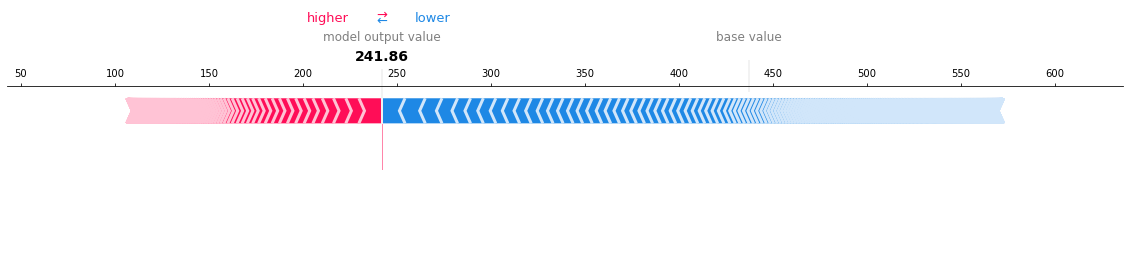

In [16]:
shap.force_plot(explainer.expected_value, shap_value, feature_names=columns, matplotlib=True)

How to read this chart:

For sample i,

- The red sections on the left are features which push the model towards the final prediction in the positive direction (i.e. increasing the value of these features will result in higher predicted value). In this case the actual value for sample i is actually "0". So red features which increases the prediction are **bad**.

- The blue sections on the right are features that push the model towards the final prediction in the negative direction (i.e. increase in such feature values leads to a lower prediction). In this case the actual value for sample i is actually "0". So blue features which decreases the prediction are **good**. 

We can also use SHAP values to understand the model output in aggregate. Run the next cell to initialize the SHAP values (this may take a few minutes).

In nutshell:

Each feature value is a force that either increases or decreases the prediction. The prediction starts from the baseline. The baseline for Shapley values is the average of all predictions. In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. These forces balance each other out at the actual prediction of the data instance.

###### Feature Importance 

The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data:

In [17]:
shap_values = shap.TreeExplainer(rf).shap_values(xtest_df)

In [18]:
shap_values.shape

(78000, 472)

In [19]:
feature_imp = np.mean(np.abs(shap_values),axis=0)
feature_imp.shape

(472,)

In [20]:
# top 20 important features
ind = feature_imp.argsort()[-20:]
ind = ind[::-1] #arranging in descending order

In [21]:
np.array(columns)[ind]

array(['sample147', 'sample6', 'sample21', 'sample229', 'sample162',
       'sample226', 'sample413', 'sample159', 'sample178', 'sample362',
       'sample120', 'sample308', 'sample84', 'sample192', 'sample225',
       'sample311', 'sample291', 'sample219', 'sample163', 'sample228'],
      dtype='<U9')

In [22]:
feature_imp[ind]

array([17.29198376, 17.06467541, 16.68482537, 13.4735839 , 11.28185214,
        8.01924178,  7.08244125,  6.49317606,  5.73868313,  5.05856162,
        4.90471274,  4.77721346,  4.34409595,  3.99947658,  3.82934659,
        3.73703734,  3.72674888,  3.3861553 ,  3.3404312 ,  3.1044708 ])

[Text(0, 0, 'sample147'),
 Text(0, 0, 'sample6'),
 Text(0, 0, 'sample21'),
 Text(0, 0, 'sample229'),
 Text(0, 0, 'sample162'),
 Text(0, 0, 'sample226'),
 Text(0, 0, 'sample413'),
 Text(0, 0, 'sample159'),
 Text(0, 0, 'sample178'),
 Text(0, 0, 'sample362'),
 Text(0, 0, 'sample120'),
 Text(0, 0, 'sample308'),
 Text(0, 0, 'sample84'),
 Text(0, 0, 'sample192'),
 Text(0, 0, 'sample225'),
 Text(0, 0, 'sample311'),
 Text(0, 0, 'sample291'),
 Text(0, 0, 'sample219'),
 Text(0, 0, 'sample163'),
 Text(0, 0, 'sample228')]

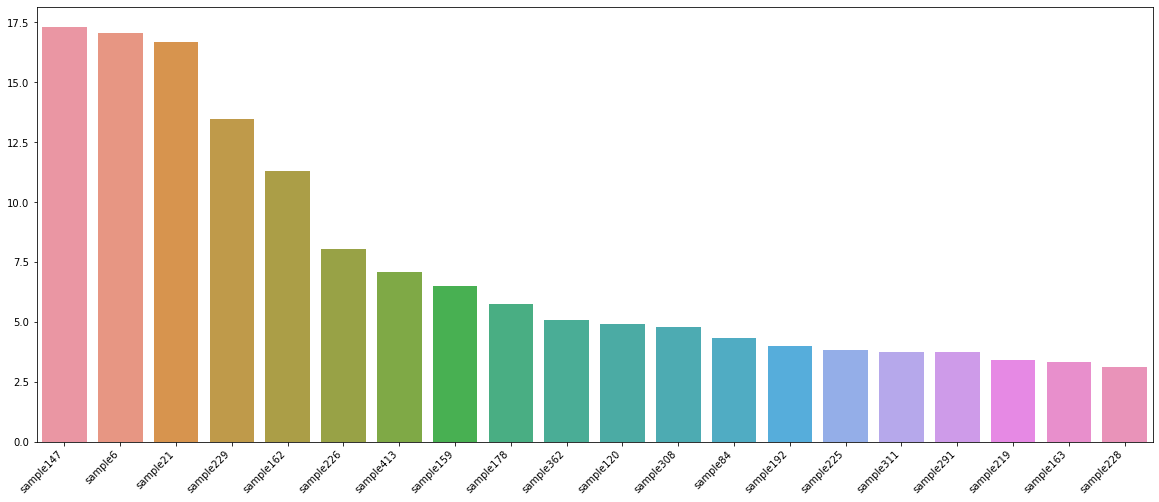

In [24]:
plt.figure(figsize=(20,8))
plot = sns.barplot(x=np.array(columns)[ind],y=feature_imp[ind])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

###### Summary plots

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

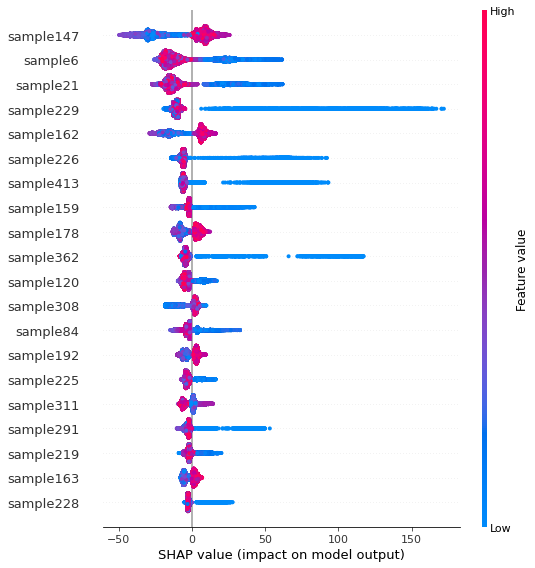

In [25]:
shap.summary_plot(shap_values, xtest_df)

Clearly we see that high values of (sample6 and sample21 and some others) has a negative SHAP value, meaning that increasing the distance from these samples reduces the output values and coming closer to these samples increases the output values. In other words these samples should be of high grade to show such behaviour. 

###### Dependence plots

You can see how features interact using dependence plots. These plot the SHAP value for a given feature for each data point, and color the points in using the value for another feature. This lets us begin to explain the variation in SHAP value for a single value of the main feature.

Run the next cell to see the interaction between Age and Sex.

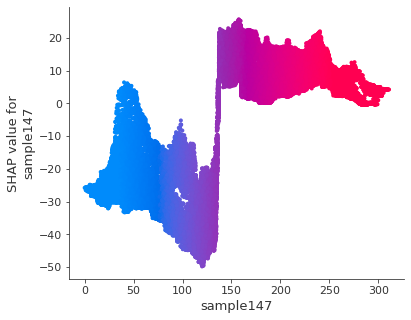

In [26]:
shap.dependence_plot('sample147', shap_values, xtest_df, interaction_index='sample147')

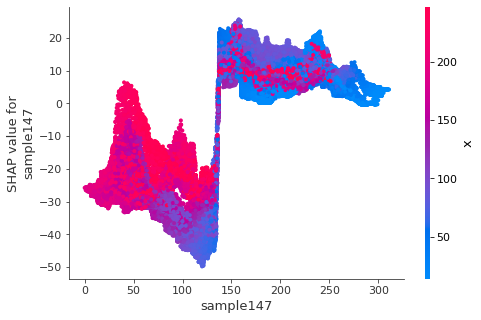

In [27]:
shap.dependence_plot('sample147', shap_values, xtest_df, interaction_index='x')

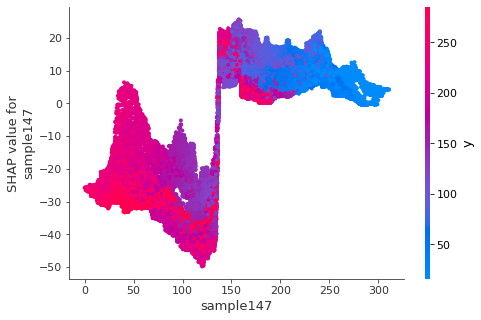

In [28]:
shap.dependence_plot('sample147', shap_values, xtest_df, interaction_index='y')

### Further Analysis specific to this technique of Random Forest based Spatial Estimation

###### Visualizing feature importance after taking absolute mean of shapely values for each feature

In [29]:
feature_imp = np.mean((np.abs(shap_values)),axis=0)

In [30]:
feature_imp[2:].shape

(470,)

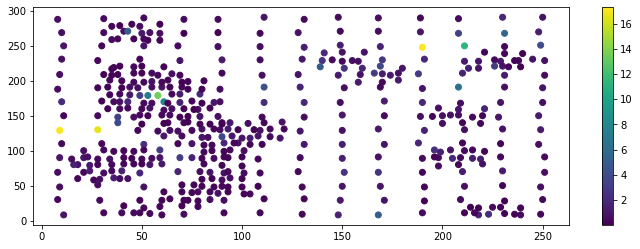

In [31]:
plt.figure(figsize=(12,4))
plt.scatter(train['x'],train['y'],c=feature_imp[2:])
plt.colorbar()

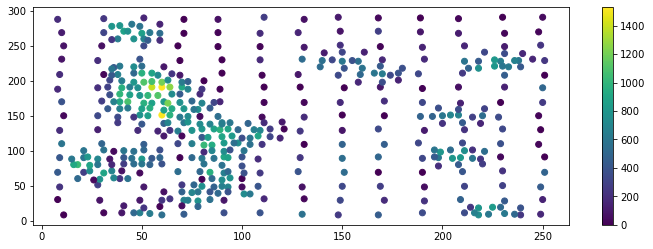

In [32]:
plt.figure(figsize=(12,4))
plt.scatter(train['x'],train['y'],c=train['v'])
plt.colorbar()

###### Visualizing feature importance after taking only mean without absolute of shapely values for each feature

In [33]:
feature_imp = np.mean((shap_values),axis=0)

In [34]:
feature_imp[2:].shape

(470,)

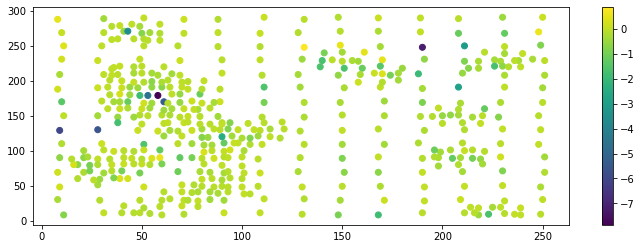

In [35]:
plt.figure(figsize=(12,4))
plt.scatter(train['x'],train['y'],c=feature_imp[2:])
plt.colorbar()

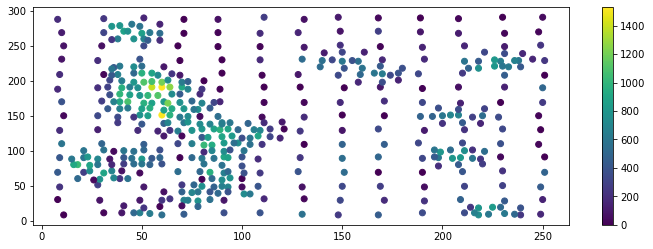

In [36]:
plt.figure(figsize=(12,4))
plt.scatter(train['x'],train['y'],c=train['v'])
plt.colorbar()